In [2]:
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def cv_show(name,img):
    cv2.namedWindow(name,0)
    cv2.resizeWindow(name,700,900)
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
raw_person = cv2.imread('images/person.png')
cv_show('raw_person', raw_person)

In [5]:
gray_person = cv2.imread('images/person.png', flags=cv2.IMREAD_GRAYSCALE)
cv_show('gray_person', gray_person)
cv2.imwrite('results/person/gray_person.jpg',gray_person)

True

C:\Users\user\AppData\Local\Temp\ipykernel_7412\264113271.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist = np.histogram(gray_person, bins=np.arange(0, 256), normed=True)


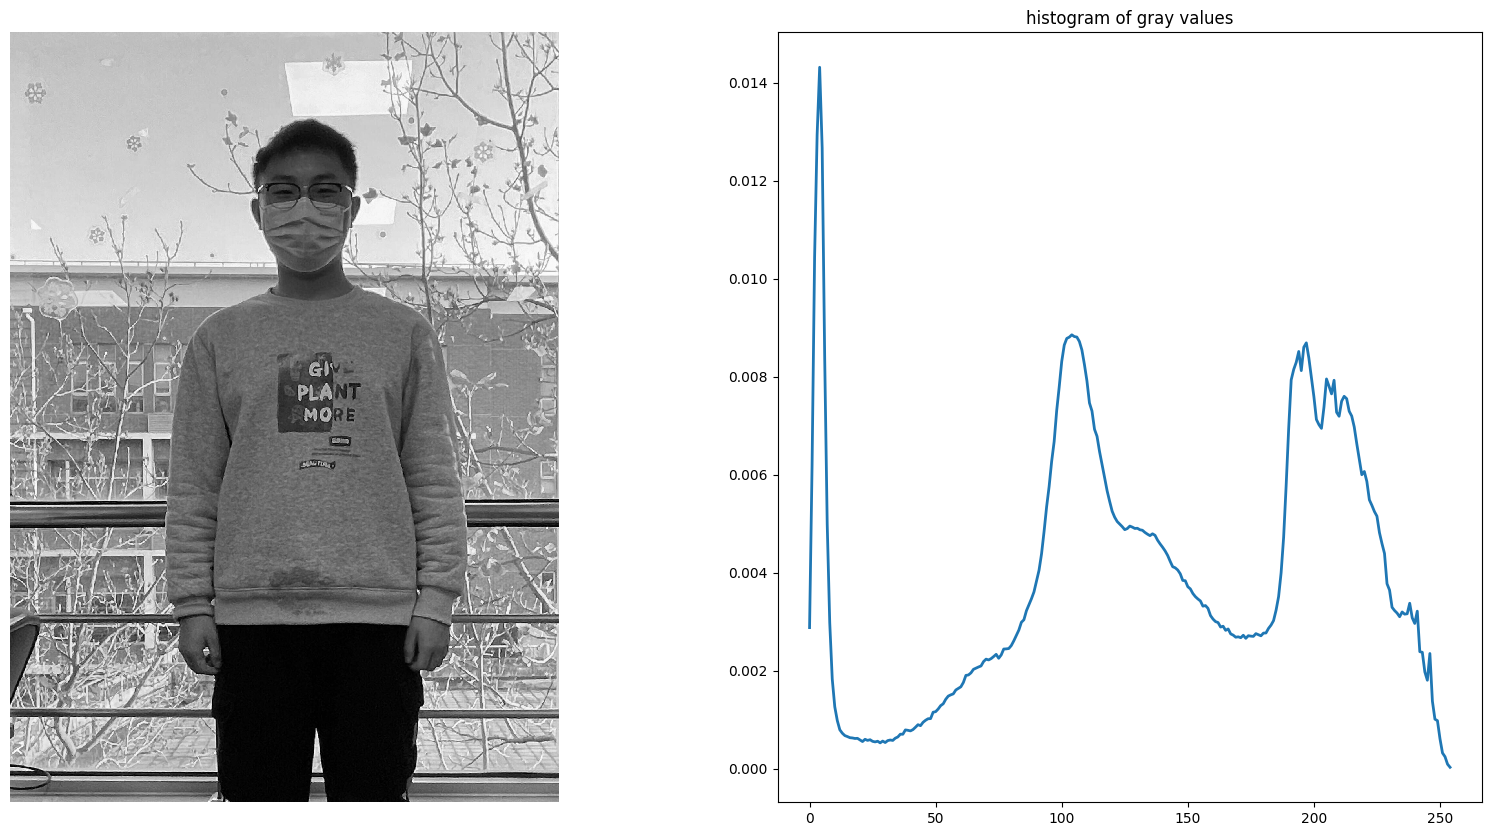

In [6]:
import numpy as np
hist = np.histogram(gray_person, bins=np.arange(0, 256), normed=True)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(gray_person, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of gray values')
plt.show()

In [7]:
def img_morph(img, size=5, method='open', element='rect'):
    '''
    img: binary image
    size: the size of square used to do morphological filtering
    method: open or close or erode or dilate
    element: structure element, rect or circle or cross
    '''
    if element == 'rect':
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    elif element == 'circle':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    elif element == 'cross':
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (size, size))

    if method == 'open':
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    elif method == 'close':
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    elif method == 'erode':
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    elif method == 'dilate':
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    
    return img


In [8]:
t0=170
segmented_gray_img2 = np.where(gray_person[...,:] < t0, 255, 0).astype(np.uint8)

cv_show('segmented_gray_image',segmented_gray_img2)

In [9]:
open_person=img_morph(segmented_gray_img2,size=200,method='open')
cv_show('open_person', open_person)

In [10]:
dilate_person=img_morph(open_person,size=10,method='dilate')
cv_show('dilate_person', dilate_person)

In [11]:
close_person=img_morph(dilate_person,size=100,method='close')
cv_show('close_person', close_person)

In [12]:
dilate_person1=img_morph(close_person,size=20,method='dilate')
cv_show('dilate_person1', dilate_person1)

In [13]:
segmented_person=cv2.bitwise_and(raw_person,raw_person,mask=dilate_person1)
cv_show('segmented_person', segmented_person)
cv2.imwrite('results/person/segmented_threshold_person.jpg',segmented_person)

True

In [14]:
def region_grow(img, seeds, threshold):
    '''
    select the bgd pixel attentionally to simplify the problem
    img: gray scale image
    seeds: the seed pixels
    '''
    seed_list = seeds
    neighbors = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
    is_search = np.zeros(img.shape)
    is_add = np.zeros(img.shape)
    for seed in seeds:
        is_add[seed[0], seed[1]] = 1
    grow_img = np.ones(img.shape).astype(np.uint8)*255
    # mean_value = img[seed[0], seed[1]]
    cnt = 1
    while(len(seed_list)>0):
        cnt += 1
        seed = seed_list.pop()
        grow_img[seed[0], seed[1]] = 0
        is_search[seed[0], seed[1]] = 1
        for neighbor in neighbors:
            # print(neighbor, seed)
            neighbor_x = seed[0]+neighbor[0]
            neighbor_y = seed[1]+neighbor[1]
            if neighbor_x < 0 or neighbor_y < 0 or neighbor_x >= img.shape[0] or neighbor_y >= img.shape[1]:
                continue
            elif is_search[neighbor_x, neighbor_y] == 1 or is_add[neighbor_x, neighbor_y] == 1:
                continue
            # elif abs(img[neighbor_x, neighbor_y] - mean_value) > threshold:
            elif abs(float(img[neighbor_x, neighbor_y]) - float(img[seed[0],seed[1]])) > threshold:
                continue
            else:
                seed_list.insert(0, [neighbor_x, neighbor_y])
                is_add[neighbor_x, neighbor_y] = 1
                # mean_value = mean_value/cnt+img[neighbor_x, neighbor_y]/cnt
                # print(mean_value)
                # grow_img[neighbor_x, neighbor_y] = 0
    return grow_img

In [15]:
seeds = [[341,942],[1510,960],[773,931],[2018,949]]
grow_person = region_grow(gray_person, seeds, 4)
grow_person = 255-grow_person
cv_show('grow_person',grow_person)

In [16]:
open_grow_person=img_morph(grow_person,size=50,method='open')
cv_show('open_grow_person', open_grow_person)

In [17]:
close_grow_person1=img_morph(open_grow_person,size=200,method='close')
cv_show('close_grow_person1', close_grow_person1)

In [18]:
segmented_region_person = cv2.bitwise_and(raw_person,raw_person,mask= close_grow_person1)
cv_show('segmented_region_person',segmented_region_person)
cv2.imwrite('results/person/segmented_region_person.jpg',segmented_region_person)

True